## チュートリアル（処理済み検索ログを使う場合）

In [2]:
# ========================================
# Library
# ========================================
import math
import random
import pickle
import itertools
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
# import jpholiday
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import (
    TimeSeriesSplit,
    StratifiedKFold,
    KFold,
    GroupKFold,
    StratifiedGroupKFold,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from scipy.optimize import minimize
import lightgbm as lgb

In [2]:
i_path = '../input/'
o_path = './output/'

In [3]:
def load_datas(folder_path):
    """folder_path配下のcsvを繋げてreturnする"""
    paths = glob(folder_path+'/*.csv')
    dfs = []
    for path in paths:
        df = pd.read_csv(path)
        dfs.append(df)
    df_output = pd.concat(dfs)
    return df_output.reset_index(drop=True)

In [4]:
train_df = load_datas(i_path + 'train')
road_df = pd.read_csv(i_path + 'road_local.csv')
search_spec_df = load_datas(i_path + 'search_specified')
search_unspec_df = pd.read_csv(i_path + 'search_unspecified.csv')

In [5]:
def expand_datetime(df):
    if 'datetime' in df.columns:
        df['year'] = df['datetime'].dt.year
        df['month'] = df['datetime'].dt.month
        df['day'] = df['datetime'].dt.day
        df['hour'] = df['datetime'].dt.hour
    if 'date' in df.columns:
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
    return df

In [6]:
def extract_dataset(train_df, search_spec_df, search_unspec_df):
    train_df['datetime'] = pd.to_datetime(train_df['datetime'])
    search_spec_df['datetime'] = pd.to_datetime(search_spec_df['datetime'])
    search_unspec_df['date'] = pd.to_datetime(search_unspec_df['date'])

    train_df = expand_datetime(train_df)
    search_unspec_df = expand_datetime(search_unspec_df)

    train_df = train_df.merge(search_spec_df, on=['datetime', 'start_code', 'end_code'], how='left')
    train_df = train_df.merge(search_unspec_df, on=['year', 'month', 'day', 'start_code', 'end_code'], how='left')
    train_df = train_df.merge(road_df.drop(['start_name', 'end_name'], axis=1), on=['start_code', 'end_code'], how='left')

    train_df['dayofweek'] = train_df['datetime'].dt.weekday

    return train_df

In [7]:
train = extract_dataset(train_df, search_spec_df, search_unspec_df)

In [8]:
train['section'] = train['start_code'].astype(str) + '_' + train['KP'].astype(str) + '_' + train['end_code'].astype(str)

In [9]:
cat_cols = ['road_code', 'start_code', 'end_code', 'section', 'direction', 'hour', 'dayofweek']
num_cols = ['year', 'month', 'day', 'hour', 'search_specified', 'search_unspecified', 'KP', 'start_KP', 'end_KP', 'limit_speed']
feature_cols = cat_cols + num_cols

In [10]:
train[feature_cols]

,road_code,start_code,end_code,section,direction,hour,dayofweek,year,month,day,hour,search_specified,search_unspecified,KP,start_KP,end_KP,limit_speed
0,1800,1110210,1800006,1110210_2.48_1800006,下り,0,3,2021,4,8,0,15.0,3419.0,2.480,0.8,9.4,100.0
1,1800,1110210,1800006,1110210_2.48_1800006,下り,1,3,2021,4,8,1,6.0,3419.0,2.480,0.8,9.4,100.0
2,1800,1110210,1800006,1110210_2.48_1800006,下り,2,3,2021,4,8,2,3.0,3419.0,2.480,0.8,9.4,100.0
3,1800,1110210,1800006,1110210_2.48_1800006,下り,3,3,2021,4,8,3,26.0,3419.0,2.480,0.8,9.4,100.0
4,1800,1110210,1800006,1110210_2.48_1800006,下り,4,3,2021,4,8,4,30.0,3419.0,2.480,0.8,9.4,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5800075,1040,1040066,1040076,1040066_79.253_1040076,下り,19,6,2022,5,1,19,23.0,8816.0,79.253,75.4,91.5,100.0
5800076,1040,1040066,1040076,1040066_79.253_1040076,下り,20,6,2022,5,1,20,36.0,8816.0,79.253,75.4,91.5,100.0
5800077,1040,1040066,1040076,1040066_79.253_1040076,下り,21,6,2022,5,1,21,39.0,8816.0,79.253,75.4,91.5,100.0
5800078,1040,1040066,1040076,1040066_79.253_1040076,下り,22,6,2022,5,1,22,46.0,8816.0,79.253,75.4,91.5,100.0


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5800080 entries, 0 to 5800079
Data columns (total 30 columns):
 #   Column              Dtype         
---  ------              -----         
 0   datetime            datetime64[ns]
 1   start_code          int64         
 2   end_code            int64         
 3   KP                  float64       
 4   OCC                 float64       
 5   allCars             int64         
 6   speed               float64       
 7   is_congestion       int64         
 8   year                int32         
 9   month               int32         
 10  day                 int32         
 11  hour                int32         
 12  search_specified    float64       
 13  date                datetime64[ns]
 14  search_unspecified  float64       
 15  road_code           int64         
 16  direction           object        
 17  limit_speed         float64       
 18  start_KP            float64       
 19  end_KP              float64       
 20  st

In [12]:
# ========================================
# カテゴリ変数の処理
# ========================================
le_dict = {}
for c in tqdm(cat_cols):
    le = LabelEncoder()
    train[c] = le.fit_transform(train[c])
    le_dict[c] = le

# with open("../src/features/le_dict.pkl", "wb") as f:
#     pickle.dump(le_dict, f)

100%|██████████| 7/7 [00:01<00:00,  3.65it/s]


In [13]:
# ========================================
# training module
# ========================================
def train_lgbm(X,
               y,
               cv,
               model_path = [],
               params: dict=None,
               verbose: int=100
               ):

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]


        clf = lgb.LGBMClassifier(**params)

        clf.fit(x_train, y_train,
                eval_set=[(x_valid, y_valid)],
                callbacks=[
                    lgb.early_stopping(stopping_rounds=50, verbose=True),
                    lgb.log_evaluation(100)
                ]
                )

        pred_i = clf.predict_proba(x_valid)[:,1]
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        score = roc_auc_score(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = roc_auc_score(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: CV Score: {score:.4f}")
    return score, oof_pred, models

In [14]:
# ========================================
# parameters
# ========================================
params = {
    "objective": "binary",
    "metric": "auc",
    "n_estimators": 100000,
    "learning_rate": 0.1,
    "importance_type": "gain",
    "random_state": 42,
    "verbose": -1,
}
# ========================================
# train-validation split
# ========================================
TARGET = 'is_congestion'
N_SPLIT = 5
kf = StratifiedGroupKFold(N_SPLIT)
cv_list = list(kf.split(train, y=train[TARGET], groups=train['date']))

# ========================================
# define variables
# ========================================
X = train[feature_cols].values
y = train[TARGET].values

print('train shape:', train.shape)
# ========================================
# training
# ========================================
score, oof_pred, models = train_lgbm(X, y=y, params=params, cv=cv_list)

train shape: (5800080, 30)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's auc: 0.916279
 - fold1 - 0.9163
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.907366
 - fold2 - 0.9074
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid_0's auc: 0.91858
 - fold3 - 0.9186
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	valid_0's auc: 0.891723
 - fold4 - 0.8917
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	valid_0's auc: 0.902615
 - fold5 - 0.9026
FINISHI: CV Score: 0.8974


In [15]:
# 最適な閾値を探索

def func(x_list, df, oof):
    score = f1_score(df[TARGET], oof>x_list[0])
    return -score

x0 = [0.5]
result = minimize(func, x0,  args=(train, oof_pred), method="nelder-mead")
threshold = result.x[0]
train['pred'] = (oof_pred>threshold).astype(int)
print('threshold:', threshold)
print(classification_report(train[TARGET], train['pred']))

threshold: 0.12031249999999966
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5779316
           1       0.31      0.27      0.29     20764

    accuracy                           1.00   5800080
   macro avg       0.66      0.63      0.64   5800080
weighted avg       0.99      1.00      1.00   5800080



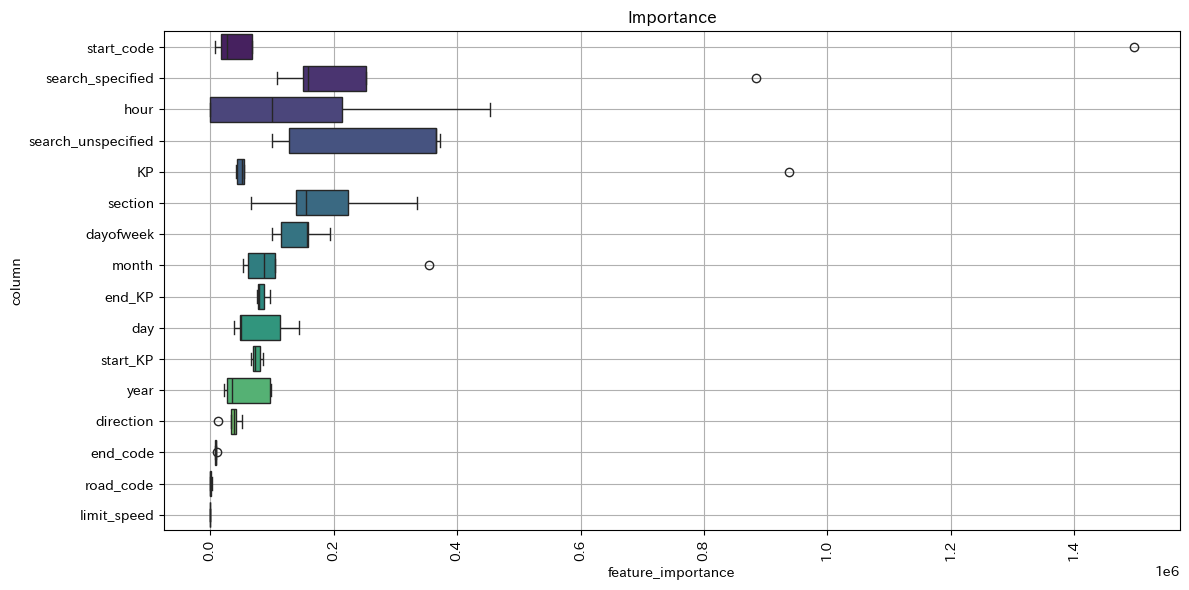

In [16]:
# ========================================
# feature importance
# ========================================
def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    sns.boxplot(data=feature_importance_df,
                  x="feature_importance",
                  y="column",
                  order=order,
                  ax=ax,
                  palette="viridis",
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax, feature_importance_df

fig, ax, feature_importance_df = visualize_importance(models, train[feature_cols])

# チュートリアル（ドラぷら検索ログの処理を含む）

In [4]:
# ========================================
# Library
# ========================================
import os
import math
import time
import random
import pickle
import itertools
import warnings
warnings.filterwarnings('ignore')

import networkx as nx
import numpy as np
import pandas as pd
from datetime import datetime
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import jpholiday
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import (
    TimeSeriesSplit,
    StratifiedKFold,
    KFold,
    GroupKFold,
    StratifiedGroupKFold,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from scipy.optimize import minimize
import lightgbm as lgb

In [5]:
from expressway_router import ExpresswayRouter

road_all_csv = "./input/road_all.csv"
road_local_csv = "./input/road_local.csv"
router = ExpresswayRouter(road_all_csv=road_all_csv, road_local_csv=road_local_csv)

ModuleNotFoundError: No module named 'expressway_router'

In [19]:
#2021年4月分のデータのみ抜き出す
log_pathes = glob("./input/search_raw_log/2021_04_*.csv")
sorted_pathes = sorted(log_pathes, key=lambda x: datetime.strptime(os.path.basename(x), '%Y_%m_%d.csv'))
print(sorted_pathes[:5])

['./input/search_raw_log/2021_04_01.csv', './input/search_raw_log/2021_04_02.csv', './input/search_raw_log/2021_04_03.csv', './input/search_raw_log/2021_04_04.csv', './input/search_raw_log/2021_04_05.csv']


In [20]:
rawlog_df = pd.concat([pd.read_csv(path) for path in sorted_pathes]).reset_index(drop=True)
rawlog_df = rawlog_df.astype({
    'datetime': 'datetime64[ns]',
    'start_code': 'category',
    'end_code': 'category',
    # 'spec_datetime': 'datetime64[ns]',
    'spec_type': 'category',
    'car_type': 'category'
    })
rawlog_df['spec_datetime'] = pd.to_datetime(rawlog_df['spec_datetime'], format='ISO8601')


In [21]:
rawlog_df.head(3)

,datetime,start_code,end_code,spec_datetime,spec_type,car_type
0,2021-04-01 00:00:01,6016021,1461150,2021-03-31 06:00:00,1,2
1,2021-04-01 00:00:06,214K106,1010066,2021-04-01 00:00:00,1,2
2,2021-04-01 00:00:06,6016021,1461150,2021-03-31 07:00:00,1,2


In [22]:
rawlog_df.tail(3)

,datetime,start_code,end_code,spec_datetime,spec_type,car_type
1911903,2021-04-30 23:59:53,1040076,1040061,2021-04-30 02:00:00,1,2
1911904,2021-04-30 23:59:53,1800061,1810026,2021-04-30 00:00:00,1,2
1911905,2021-04-30 23:59:55,1421003,1410001,2021-04-30 01:00:00,1,2


In [23]:
rawlog_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1911906 entries, 0 to 1911905
Data columns (total 6 columns):
 #   Column         Dtype         
---  ------         -----         
 0   datetime       datetime64[ns]
 1   start_code     category      
 2   end_code       category      
 3   spec_datetime  datetime64[ns]
 4   spec_type      category      
 5   car_type       category      
dtypes: category(4), datetime64[ns](2)
memory usage: 40.3 MB


In [24]:
def get_past_logs(df_log: pd.DataFrame, date: str, n_days: int) -> pd.DataFrame:
    '''
    df_logに含まれる、dateからn_days日前までの検索ログのうち、dateを指定日とするレコードを抜き出す
    '''
    end_timestamp = pd.Timestamp(date)
    start_timestamp = end_timestamp - pd.Timedelta(n_days, unit='day')
    
    df = df_log.loc[
        (df_log.datetime >= start_timestamp) & (df_log.datetime < end_timestamp)
    ]
    
    df_specified = df.loc[
        df.spec_datetime.dt.date == end_timestamp
    ].reset_index(drop=True)
    return df_specified

In [25]:
def create_expected_passing_time_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    '''
    検索ログdfの1レコードごとに検索経路が通過する各区間の予想通過時刻を計算する
    '''
    start_codes = []
    end_codes = []
    expected_passing_times = []
    
    columns = ['start_code', 'end_code', 'spec_datetime', 'spec_type']
    for (src, dest, spec_datetime, spec_type) in df.loc[:, columns].values:
        path_with_time = router.get_route_with_time(src, dest, spec_datetime, spec_type)
        
        for ((start_code, passing_time), (end_code, _)) in zip(path_with_time, path_with_time[1:]):
            start_codes.append(start_code)
            end_codes.append(end_code)
            expected_passing_times.append(passing_time)

    return pd.DataFrame({
        'start_code': start_codes,
        'end_code': end_codes,
        'passing_time': expected_passing_times
    }).astype({'start_code': 'category', 'end_code': 'category'})

In [26]:
data_period_dict = {
    'train': ('20210408', '20210430'), # サンプルとして1ヶ月を処理
    # 'test': ('20230801', '20230930'),
}

In [27]:
# 何日前までの検索履歴を参照するか
n_days = 7
# 検索数の時間粒度
sampling_rate = '1h'

## ドラぷら検索ログの処理

In [3]:
passing_df

NameError: name 'passing_df' is not defined

In [31]:
# 訓練データ期間
start_date, end_date = data_period_dict['train']
date_range = pd.date_range(start_date, end_date, freq='1d')

search_df = pd.DataFrame()
s = time.time()
for date in date_range:
    _s = time.time()
    
    past_logs_df = get_past_logs(rawlog_df, date, n_days=7)
    passing_df = create_expected_passing_time_dataframe(past_logs_df)
    
    _search_df = (passing_df.set_index('passing_time')
                  .assign(search_specified=1)
                  .groupby(['start_code', 'end_code'])
                  .apply(lambda g: g['search_specified'].resample(sampling_rate).sum())
                  # .apply(lambda g: g.resample(sampling_rate).sum())
                  .reset_index(drop=True))
    _search_df = _search_df.loc[_search_df['passing_time'].dt.date == date].reset_index(drop=True)

    
    search_df = pd.concat([search_df, _search_df], ignore_index=True)
    
    print(f'{date.date()} | {time.time() - _s : .3f} [sec]')

print('-'*30)
print(f'{start_date} --> {end_date} ({len(date_range)} days) | {time.time() - s : .3f} [sec]')

KeyError: 'passing_time'

In [ ]:
# テストデータ期間
# start_date, end_date = data_period_dict['test']
# date_range = pd.date_range(start_date, end_date, freq='1d')

# search_df = pd.DataFrame()
# s = time.time()
# for date in date_range:
#     _s = time.time()
    
#     past_logs_df = get_past_logs(rawlog_df, date, n_days=7)
#     passing_df = create_expected_passing_time_dataframe(past_logs_df)
    
#     _search_df = (passing_df.set_index('passing_time')
#                   .assign(search_specified=1)
#                   .groupby(['start_code', 'end_code'])
#                   .apply(lambda g: g['search_specified'].resample(sampling_rate).sum())
#                   .reset_index())
#     _search_df = _search_df.loc[_search_df.passing_time.dt.date == date].reset_index(drop=True)
    
#     search_df = pd.concat([search_df, _search_df], ignore_index=True)
    
#     print(f'{date.date()} | {time.time() - _s : .3f} [sec]')

# print('-'*30)
# print(f'{start_date} --> {end_date} ({len(date_range)} days) | {time.time() - s : .3f} [sec]')

In [ ]:
search_df.head()

In [ ]:
search_df.tail()

## トラカンデータとマージ

In [ ]:
column_types = {
    'datetime': np.datetime64,
    'start_code': str,
    'end_code': str,
}

train_df = pd.read_csv('train.csv').astype(column_types)
# test_df = pd.read_csv('test.csv').astype(column_types)

In [ ]:
# 訓練データ
train = train_df.merge(
    search_df,
    how='left',
    left_on=['datetime', 'start_code', 'end_code'],
    right_on=['passing_time', 'start_code', 'end_code']
).drop('passing_time', axis=1)

train['search_specified'] = train['search_specified'].fillna(0)


# テストデータ
# test = test_df.merge(
#     search_df,
#     how='left',
#     left_on=['datetime', 'start_code', 'end_code'],
#     right_on=['passing_time', 'start_code', 'end_code']
# ).drop('passing_time', axis=1)

# test['search_specified'] = test['search_specified'].fillna(0)

In [ ]:
train.head()